## Tutorial for running cNMF on the 10X PBMC dataset used in the [SEURAT](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html) and [SCANPY](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorials.

Note: This is the original tutorial but edited to replace shell commands with calls to the relevant functions in this package.

We use scanpy for the basic filtering and plotting of the cNMF results so see [their documentation](https://scanpy-tutorials.readthedocs.io/en/latest/index.html#) for more details on that.

 - Current as of November 18 2020
 - Email dkotliar@broadinstitute.org with questions
 

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import cNMF as cnmf

if not os.path.exists('example_PBMC'):
    os.mkdir('example_PBMC')
    
np.random.seed(14)

## Download the data and copy it to the directory ./example_PBMC

In [2]:
! wget -O example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
! tar -zxvf example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz    
! mv filtered_gene_bc_matrices example_PBMC
! rm  example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz

--2020-12-17 07:04:12--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2020-12-17 07:04:12--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz’

example_PBMC/pbmc3k 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2020-12-17 07:04:12 (70.9 MB/s) - ‘example_PBMC/pbmc3k_filtere

## Load the dataset as a sparse matrix into the Scanpy structure and then filter genes that aren't observed in  at least 3 cells, and cells with fewer than 200 genes detected

In [3]:
adata = sc.read_10x_mtx(
    'example_PBMC/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',
    cache=False)

adata.var_names_make_unique()

In [4]:
## Loaded data of 2700 PBMCs with 32738 genes
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [5]:
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells


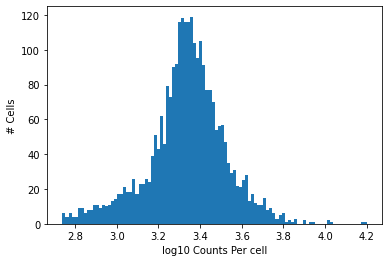

In [6]:
## plot log10 # counts per cell
plt.hist(np.log10(adata.obs['n_counts']), bins=100)
_ = plt.xlabel('log10 Counts Per cell')
_ = plt.ylabel('# Cells')

## Save the scanpy object to a file. This file will be passed as input to cNMF

In [7]:
count_adat_fn = 'example_PBMC/counts.h5ad'
sc.write(count_adat_fn, adata)

## You can also pass a text file containing the counts matrix to cNMF. The 2 cells below illustrate the format of such a file (cell x genes) with a row index containing the cell identifier and the columns containing the gene_symbols. And how you could save such it.

## These steps can be skipped for the rest of the tutorial

In [8]:
dense_data = pd.DataFrame(adata.X.todense(), index=adata.obs.index, columns=adata.var.index).astype(int)
dense_data.head()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
AAACATACAACCAC-1,0,0,0,0,0,0,0,0,0,0,...,0,10,1,0,4,0,0,0,0,0
AAACATTGAGCTAC-1,0,0,0,0,0,0,0,0,0,0,...,0,33,1,0,8,0,1,0,0,0
AAACATTGATCAGC-1,0,0,0,0,0,0,0,0,0,0,...,0,3,2,0,4,0,0,0,0,0
AAACCGTGCTTCCG-1,0,0,0,0,0,0,0,0,0,0,...,1,3,2,0,2,0,0,0,0,0
AAACCGTGTATGCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0


In [9]:
## Commented out because it is slow

count_txt_fn = 'example_PBMC/counts.tsv'
#dense_data.to_csv(count_txt_fn, sep='\t')

## In the cells below, we run the first 2 steps of cNMF assuming no parallelization:
    - prepare - normalizes the data for the run and specifies the input parameters
    - factorize - runs the actual factorization steps.
    
## With the options below, this took roughly 4 minutes on our compute configuration. To speed this up on your own runs, you can run it only for K=7-8 as those are the only Ks we look in detail at in the steps below. See the commented out K variable in the below cell

In [10]:
numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=2000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = 'example_PBMC/cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF'

## Specify the Ks to use
K = range(5,11)

seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'example_PBMC/counts.h5ad'

In [11]:
cnmf_obj = cnmf.initialize(run_name, output_directory)
cnmf.prepare(cnmf_obj, countfn, K, numgenes=numhvgenes, n_iter=numiter, seed=seed)

/home/sramesh/software/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
## Submitting all of the factorization jobs for only one worker
cnmf.factorize(cnmf_obj)

Starting task 0.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 1.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 2.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 3.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 4.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 5.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 6.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 7.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 8.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 9.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 10.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 11.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 12.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 13.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 14.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 15.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 16.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 17.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 18.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 19.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 20.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 21.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 22.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 23.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 24.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 25.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 26.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 27.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 28.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 29.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 30.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 31.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 32.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 33.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 34.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 35.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 36.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 37.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 38.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 39.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 40.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 41.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 42.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 43.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 44.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 45.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 46.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 47.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 48.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 49.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 50.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 51.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 52.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 53.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 54.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 55.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 56.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 57.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 58.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 59.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 60.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 61.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 62.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 63.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 64.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 65.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 66.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 67.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 68.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 69.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 70.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 71.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 72.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 73.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 74.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 75.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 76.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 77.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 78.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 79.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 80.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 81.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 82.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 83.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 84.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 85.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 86.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 87.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 88.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 89.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 90.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 91.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 92.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 93.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 94.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 95.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 96.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 97.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 98.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 99.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 100.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 101.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 102.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 103.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 104.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 105.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 106.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 107.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 108.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 109.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 110.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 111.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 112.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 113.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 114.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 115.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 116.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 117.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 118.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 119.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


## Alternatively, you could run cNMF with parallel processing. You can specify the number of CPUs you want to parallelize over in ```cnmf.factorize()```.

First the prepare step is run as before but specifying ```total_workers``` to be equal to the number of CPUs or compute nodes you want to distribute over.

On a Ubuntu-like system you can test how many CPUs are on the machine with the ```lscpu``` command

In [ ]:
! lscpu

.

.

.

Let's use 4 CPUs to run factorization.

In [14]:
numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numworkers=4 # Number of parallel factorization jobs to run. Set this to a value reflective of the number of cores on your computer.
numhvgenes=2000 ## Number of over-dispersed genes to use for running the factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = 'example_PBMC/cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF'

## Specify the Ks to use
K = range(5,11)

seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'example_PBMC/counts.h5ad'



In [15]:
# cnmf.prepare(cnmf_obj, countfn, K, numgenes=numhvgenes, n_iter=numiter, seed=seed)

In [16]:
## Using GNU parallel
## This took 4 minutes in our testing
cnmf.factorize(cnmf_obj, total_workers=4)

Starting task 0.Starting task 3.Starting task 1.


Starting task 2.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 4.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 5.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 6.
Starting task 7.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 8.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 9.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 10.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 11.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 12.
Starting task 13.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 14.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 15.
Starting task 16.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 17.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 18.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 19.
Starting task 20.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 21.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 22.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 23.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 24.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 25.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 26.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 27.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 28.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 29.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 30.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 31.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 32.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 33.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 34.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 35.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 36.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 37.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 38.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 39.
Starting task 40.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 41.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 42.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 43.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 44.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 45.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 46.
Starting task 47.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 48.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 50.
Starting task 49.
Starting task 51.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 52.
Starting task 53.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 54.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 55.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 56.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 57.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 58.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 59.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 60.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 61.
Starting task 62.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 63.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 64.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 65.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 66.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 67.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 69.Starting task 70.
Starting task 68.



/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 71.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 72.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 73.
Starting task 74.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 75.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 76.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 77.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 78.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 79.
Starting task 80.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 81.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 82.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 83.
Starting task 84.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 85.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 86.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 87.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 88.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 89.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 90.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 91.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 92.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 93.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 94.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 95.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 96.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 97.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 98.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 99.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 100.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 101.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 102.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 103.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 104.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 105.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 106.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 107.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 108.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 109.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 110.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 111.
Starting task 112.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 113.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 114.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 115.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 116.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 117.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 118.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Starting task 119.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %

## Whether or not you used parallelization in the above steps, you should resume here with the combine step below which combines the individual factorization replicates so that the consensus estimate can be taken

In [17]:
cnmf.combine(cnmf_obj)

Combining factorizations for k=5.
Combining factorizations for k=6.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Combining factorizations for k=7.
Combining factorizations for k=8.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


Combining factorizations for k=9.
Combining factorizations for k=10.


/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


## Compute the stability and error at each choice of K to see if a clear choice jumps out.

Please note that the maximum stability solution is not always the best choice depending on the application. However it is often a good starting point even if you have to investigate several choices of K

In [18]:
cnmf.k_selection_plot(cnmf_obj)

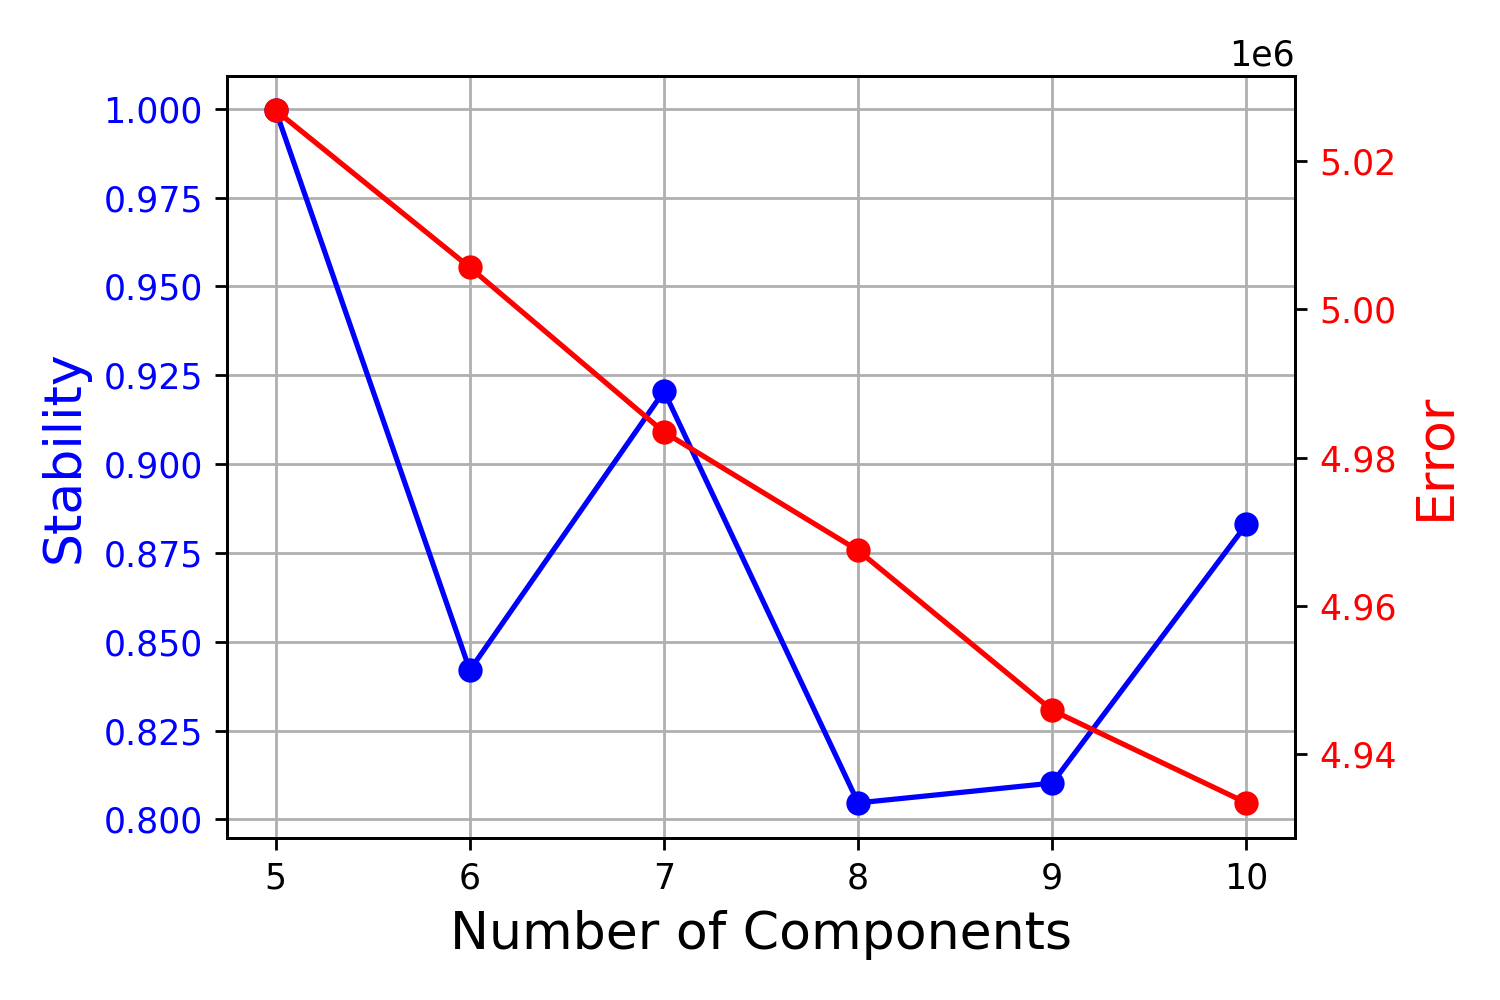

In [19]:
Image(filename = "example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.k_selection.png", width=1000, height=1000)


## In this range, K=7 gave the most stable solution so we will begin by looking at that.

The next step computes the consensus solution for a given choice of K. We first run it without any outlier filtering to see what that looks like. Setting the density threshold to anything >= 2.00 (the maximum possible distance between two unit vectors) ensures that nothing will be filtered.

Then we run the consensus with a filter for outliers determined based on inspecting the histogram of distances between components and their nearest neighbors

In [20]:
selected_K = 7
density_threshold = 2.0

In [21]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
cnmf.consensus(cnmf_obj, selected_K, density_threshold)

/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


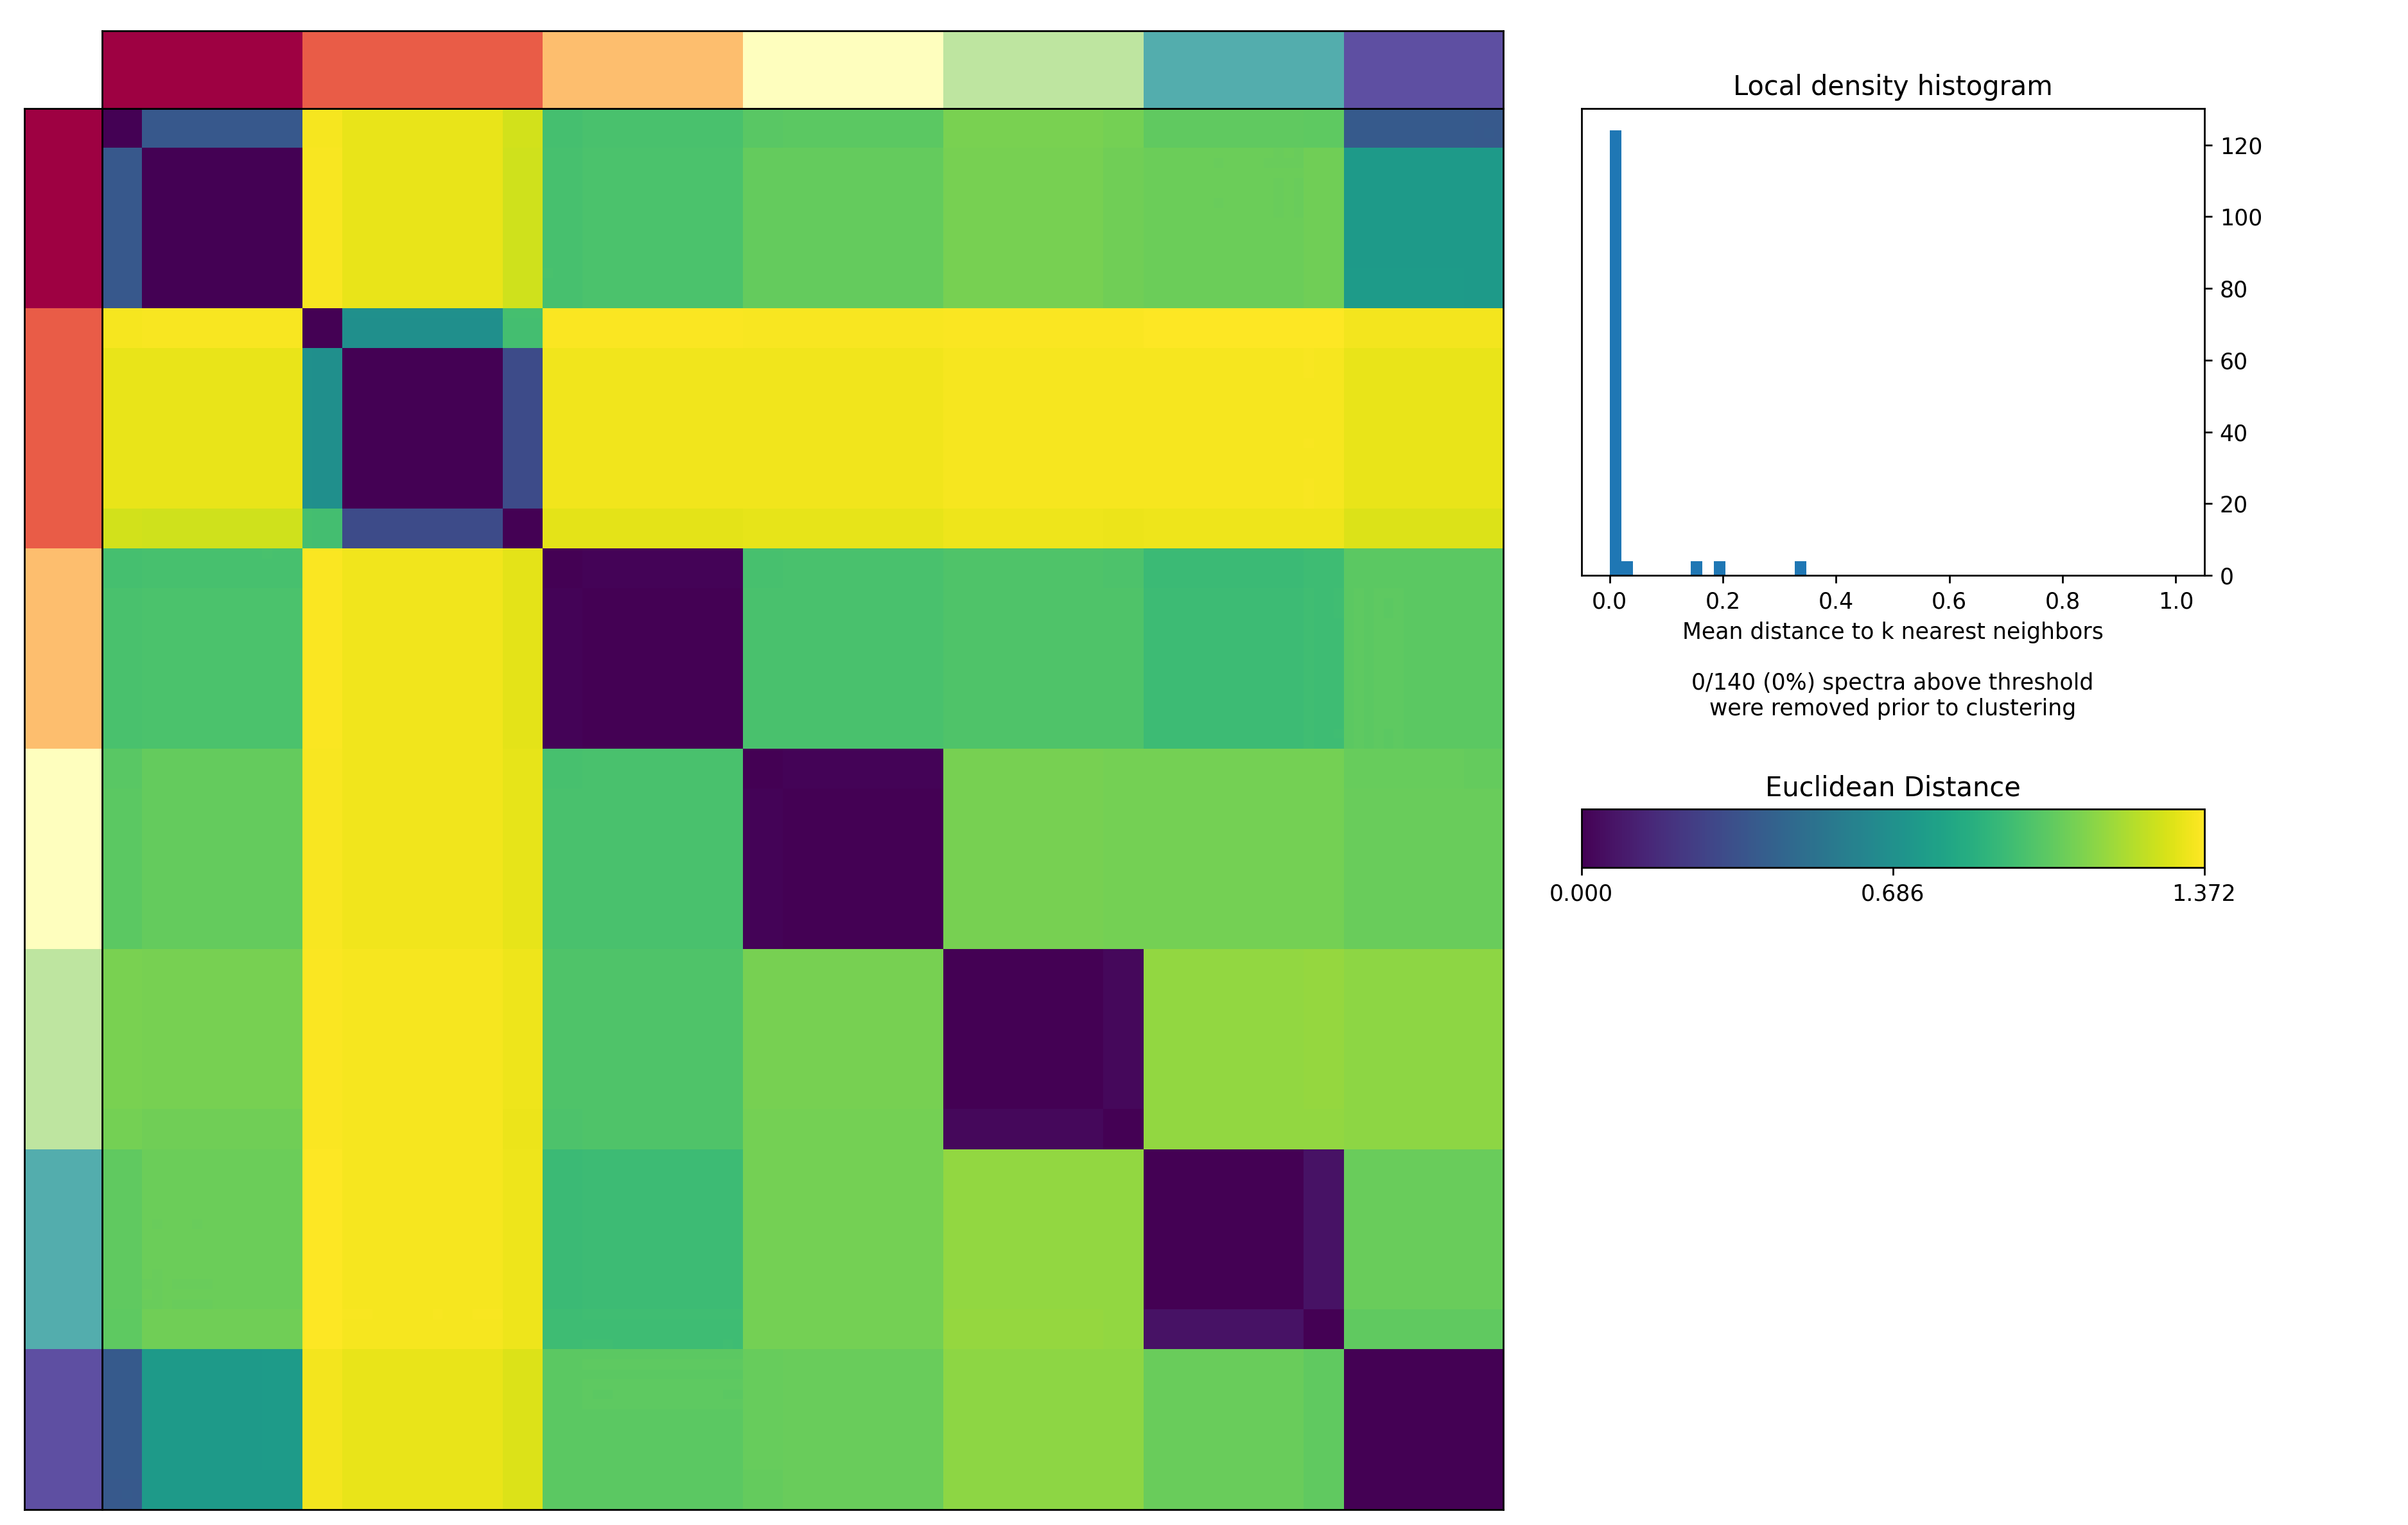

In [22]:
density_threshold_str = str(density_threshold).replace('.', '_')
Image(filename = "example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str),
      width=1000, height=1000)


The above consensus plot shows that there is a substantial degree of concordance between the replicates with a few outliers. An outlier threshold of 0.1 seems appropriate

In [23]:
density_threshold = 0.1

In [24]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
cnmf.consensus(cnmf_obj, selected_K, density_threshold)

/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


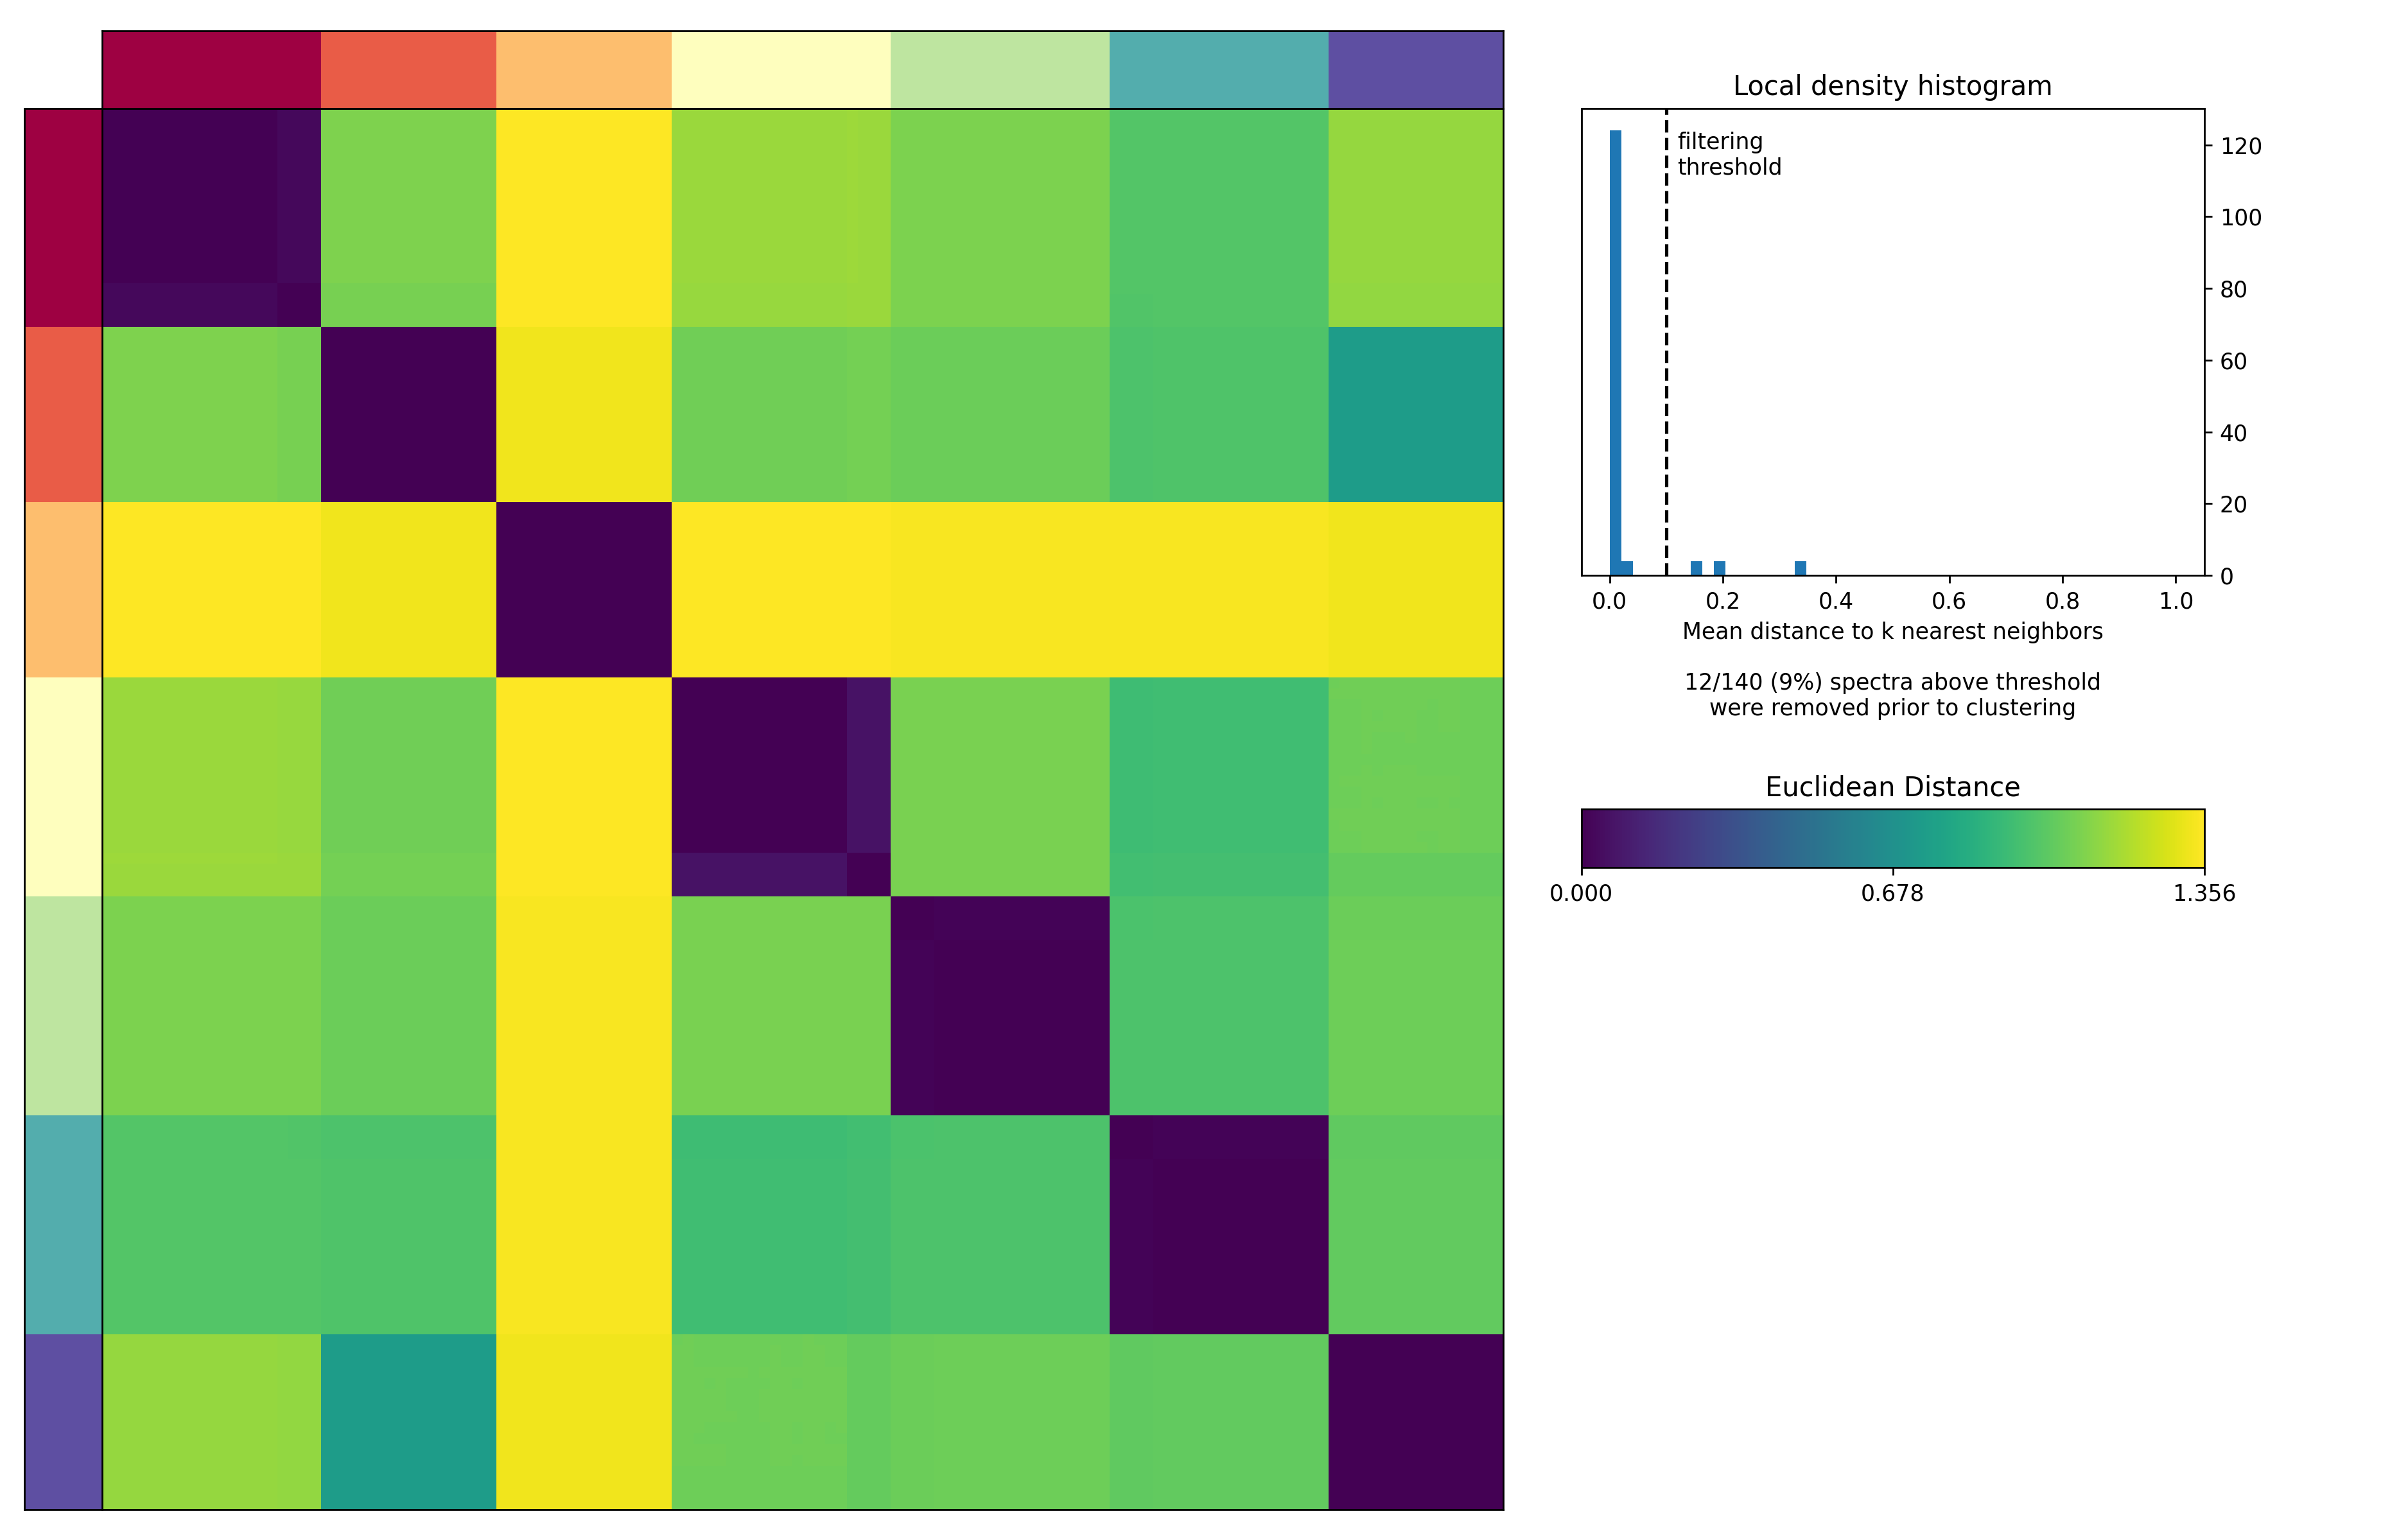

In [25]:
density_threshold_str = str(density_threshold).replace('.', '_')
Image(filename = "example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str),
      width=1000, height=1000)


## Now that we have completed the consensus step for cNMF, a number of output files have been outputted to look at

In [26]:
! ls ./example_PBMC/cNMF/pbmc_cNMF

cnmf_tmp
pbmc_cNMF.clustering.k_7.dt_0_1.png
pbmc_cNMF.clustering.k_7.dt_2_0.png
pbmc_cNMF.gene_spectra_score.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_score.k_7.dt_2_0.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_2_0.txt
pbmc_cNMF.k_selection.png
pbmc_cNMF.k_selection_stats.df.npz
pbmc_cNMF.overdispersed_genes.txt
pbmc_cNMF.spectra.k_7.dt_0_1.consensus.txt
pbmc_cNMF.spectra.k_7.dt_2_0.consensus.txt
pbmc_cNMF.usages.k_7.dt_0_1.consensus.txt
pbmc_cNMF.usages.k_7.dt_2_0.consensus.txt


We are most interested in the usage and gene_spectra_score files for the density threshold of 0.1:
  - ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.gene_spectra_score.k_7.dt_0_10.txt
  - ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.usages.k_7.dt_0_10.consensus.txt
    
Below, we load those in as text files, append them to a processed Scanpy AnnData object so we can make plots of how the usages overlap with UMAP dimensionality reudctions of the data
    

## The steps below load the AnnData object, TPT normalize it, mean and variance normalize each gene, run PCA, and run UMAP. We use the same set of high-variance genes that were determined prior to running cNMF which we obtain as the columns of the raw output file:

 - ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.spectra.k_7.dt_0_10.consensus.txt

In [27]:
adata = sc.read(countfn)

In [28]:
## Obtain high variance genes that were used for cNMF as these were saved to a text file
hvgs = open('./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.overdispersed_genes.txt').read().split('\n')

In [29]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4) ## TPT normalization

In [30]:
## Set log-normalized data to the raw attribute of the AnnData object to make it easy to plot expression levels of individual genes.
## This does not log normalize the actual AnnData data matrix
adata.raw = sc.pp.log1p(adata.copy(), copy=True)

In [31]:
## Subset out only the high-variance genes

adata = adata[:,hvgs]

In [32]:
## Mean and variance normalize the genes

sc.pp.scale(adata)

/home/sramesh/software/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [33]:
## Run PCA

sc.pp.pca(adata)

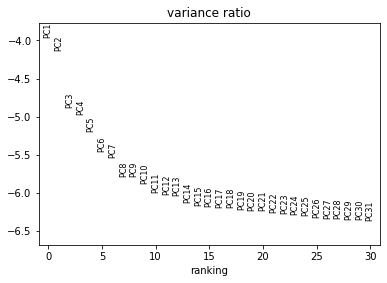

In [34]:
## Make a scree plot to determine number of PCs to use for UMAP

sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
## Construct the nearest neighbor graph for UMAP

sc.pp.neighbors(adata, n_neighbors=50, n_pcs=15)

In [36]:
## Run UMAP

sc.tl.umap(adata)

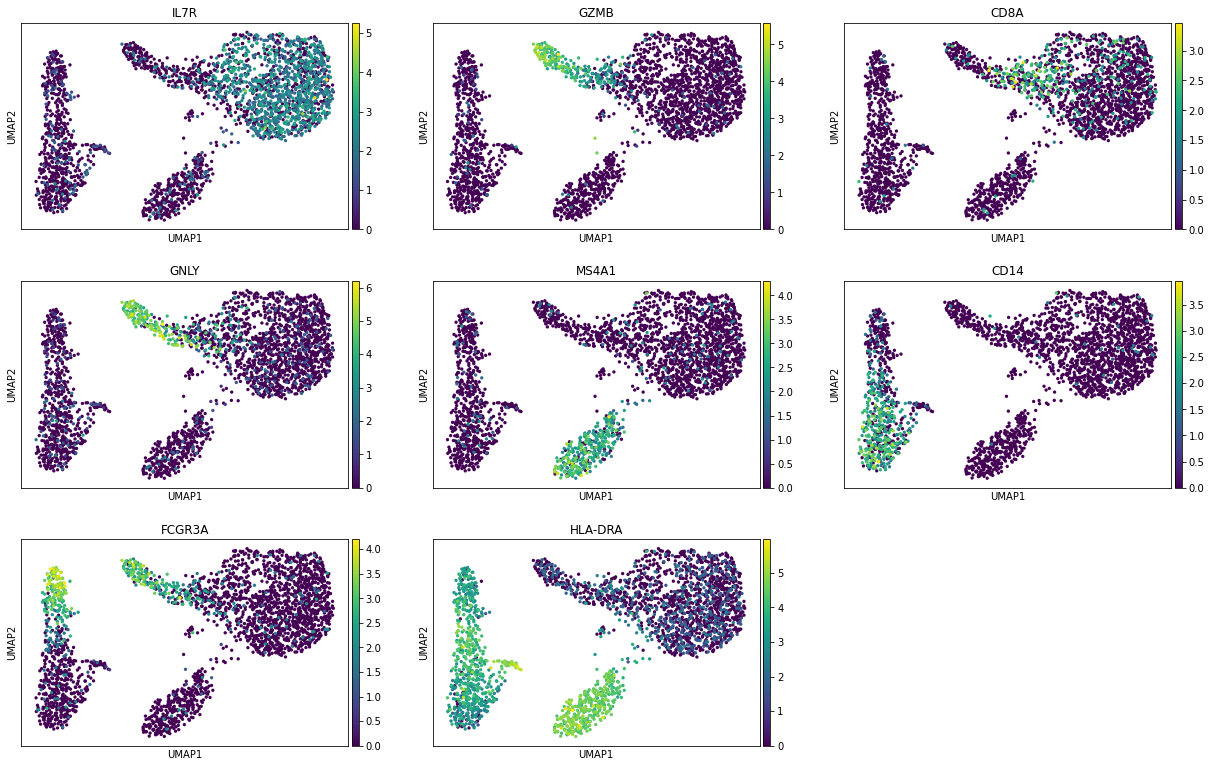

In [37]:
## Plot the UMAP with some cannonical marker genes to see that the apparent clustering makes sense

sc.pl.umap(adata, color=['IL7R', 'GZMB', 'CD8A','GNLY',
                         'MS4A1', 'CD14', 'FCGR3A', 'HLA-DRA'],
           use_raw=True, ncols=3)

## First we load the raw usage file that was output by cNMF. cNMF does not normalize the usages to sum to 1 for each cell so we can specify ```normalized = True```

In [38]:
usage = cnmf.get_usage_df(cnmf_obj, selected_K, density_threshold, normalized=False)
usage.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7
AAACATACAACCAC-1,17.166566,0.000000,0.000000,0.000000,33.134732,323.237479,2.480882
AAACATTGAGCTAC-1,29.511685,30.527200,0.000000,423.389951,62.983738,222.898077,0.000000
AAACATTGATCAGC-1,14.429999,33.970869,6.307968,0.000000,44.017957,449.723031,3.935890
AAACCGTGCTTCCG-1,7.036273,230.223196,11.848219,45.299304,31.200063,17.695581,162.205113
AAACCGTGTATGCG-1,161.717937,0.000000,0.220074,15.217456,9.441491,24.785446,38.553485


In [39]:
usage_norm = cnmf.get_usage_df(cnmf_obj, selected_K, density_threshold, normalized=True)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7
AAACATACAACCAC-1,0.045653,0.000000,0.000000,0.000000,0.088120,0.859629,0.006598
AAACATTGAGCTAC-1,0.038361,0.039681,0.000000,0.550350,0.081870,0.289737,0.000000
AAACATTGATCAGC-1,0.026123,0.061498,0.011419,0.000000,0.079687,0.814147,0.007125
AAACCGTGCTTCCG-1,0.013919,0.455430,0.023438,0.089611,0.061720,0.035006,0.320876
AAACCGTGTATGCG-1,0.647038,0.000000,0.000881,0.060885,0.037776,0.099167,0.154253


In [40]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

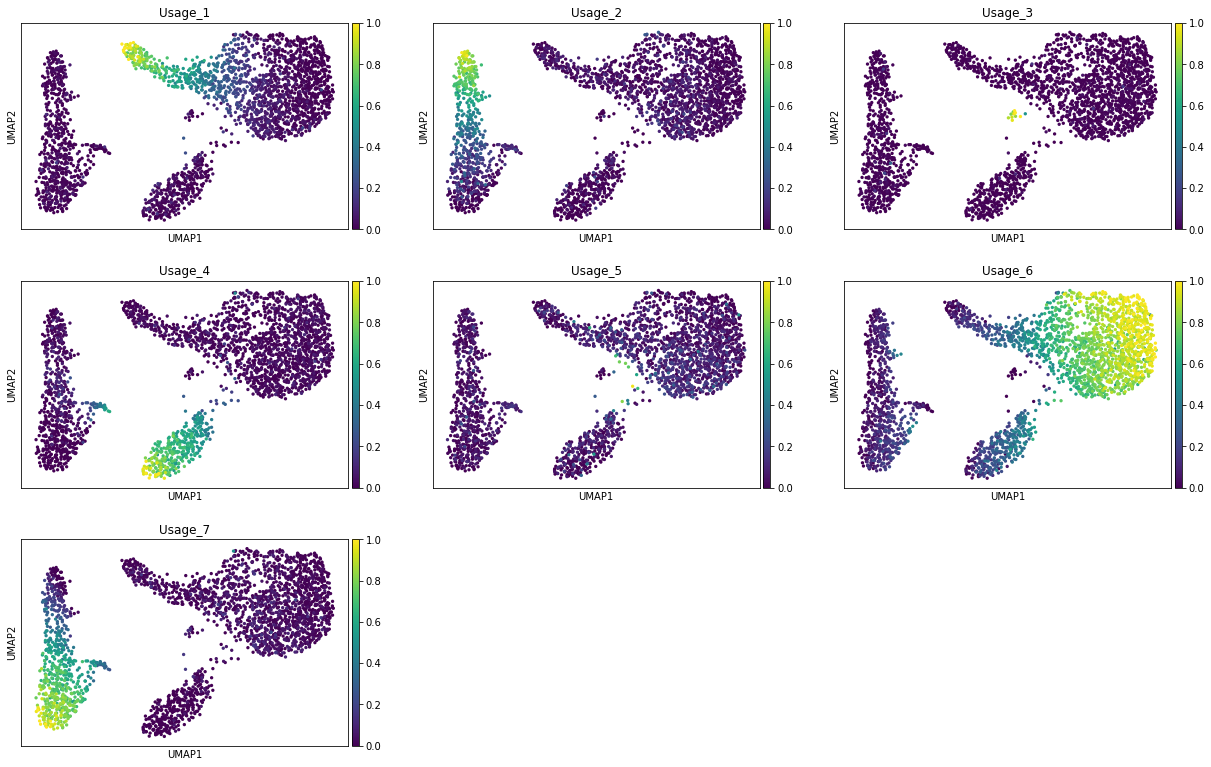

In [41]:
sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=1)

## The usages roughly overlap with the expression of marker genes in the plots above:
 - 1 - NK/CD8 T-cell identity
 - 2 - CD16+ monocyte identity
 - 4 - B-cell identity
 - 6 - CD4 T-cell identity
 - 7 CD14+ monocyte identity
 
## What is a bit less clear is the interpretation of GEP 3 and 5. Lets load in the gene_scores and identify the genes that are most associated with each program to see if we can interpret them.

In [42]:
selected_K = 7

In [43]:
density_threshold = 0.1

In [44]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = cnmf.get_gene_scores(cnmf_obj, selected_K, density_threshold)
gene_scores.head()

,1,2,3,4,5,6,7
AL627309.1,-0.000026,-0.000220,-0.000019,-0.000315,-0.000024,-0.000065,0.000582
AP006222.2,-0.000008,-0.000026,0.000002,-0.000137,-0.000046,0.000025,0.000114
RP11-206L10.2,-0.000153,-0.000104,-0.000023,0.000990,-0.000039,-0.000054,-0.000047
RP11-206L10.9,-0.000117,0.000162,-0.000055,-0.000080,-0.000022,-0.000130,0.000556
LINC00115,0.000207,0.000017,-0.000055,0.000053,-0.000024,-0.000053,0.000025


In [45]:
## Obtain the top 40 genes for each GEP in sorted order and combine them into a single dataframe
top_genes = cnmf.get_top_genes(cnmf_obj, selected_K, density_threshold, ngenes=40)
top_genes

,1,2,3,4,5,6,7
0,NKG7,FCGR3A,C2orf88,CD74,RRM2,RPS12,LYZ
1,PRF1,FCER1G,TSC22D1,HLA-DRA,CDC6,RPS27,S100A9
2,GZMB,LST1,HIST1H2AC,HLA-DQB1,MCM10,RPS25,S100A8
3,GZMA,RP11-290F20.3,AC147651.3,HLA-DQA1,TYMS,EEF1A1,CST3
4,GNLY,MS4A7,LGALSL,HLA-DPB1,KIAA0101,RPS15A,CD14
5,FGFBP2,IFITM3,ACRBP,HLA-DRB1,CDC20,RPL31,FCN1
6,SPON2,IFITM2,PTCRA,CD79B,TK1,RPS6,TYROBP
7,CST7,COTL1,MMD,HLA-DQA2,KIFC1,RPS27A,LGALS2
8,CTSW,RHOC,ESAM,MS4A1,BIRC5,RPLP2,GSTP1
9,CLIC3,AIF1,PRUNE,HLA-DPA1,BLM,RPS3A,LGALS1


## The top expressed genes for GEP 5 include common cell cycle markers such as [CDC6](https://www.ncbi.nlm.nih.gov/gene/990) and [MKI67](https://www.ncbi.nlm.nih.gov/gene/4288) suggesting that this is an activity program of cell-cycle

## GEP 3 is a bit more complicated but includes high expression of genes like [MMD](https://www.ncbi.nlm.nih.gov/gene/23531) (MMD monocyte to macrophage differentiation associated) and [ESAM](https://www.ncbi.nlm.nih.gov/gene/90952) (Endothelial cell adhesion molecule) suggesting that is may reflect a distinct stage of monocyte differentiation

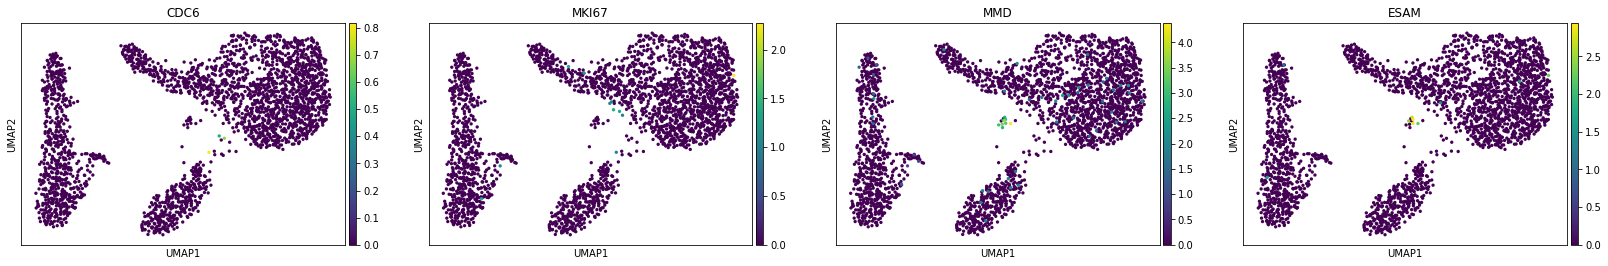

In [46]:
sc.pl.umap(adata, color=['CDC6', 'MKI67', 'MMD', 'ESAM'],
           use_raw=True, ncols=4)

## Let us quickly investigate a larger value of K to see if there are other less robust GEPs that may be worth exploring further, potentially with larger numbers of NMF replicates

In [47]:
selected_K = 8
density_threshold = 2.00

In [48]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
cnmf.consensus(cnmf_obj, selected_K, density_threshold)

/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


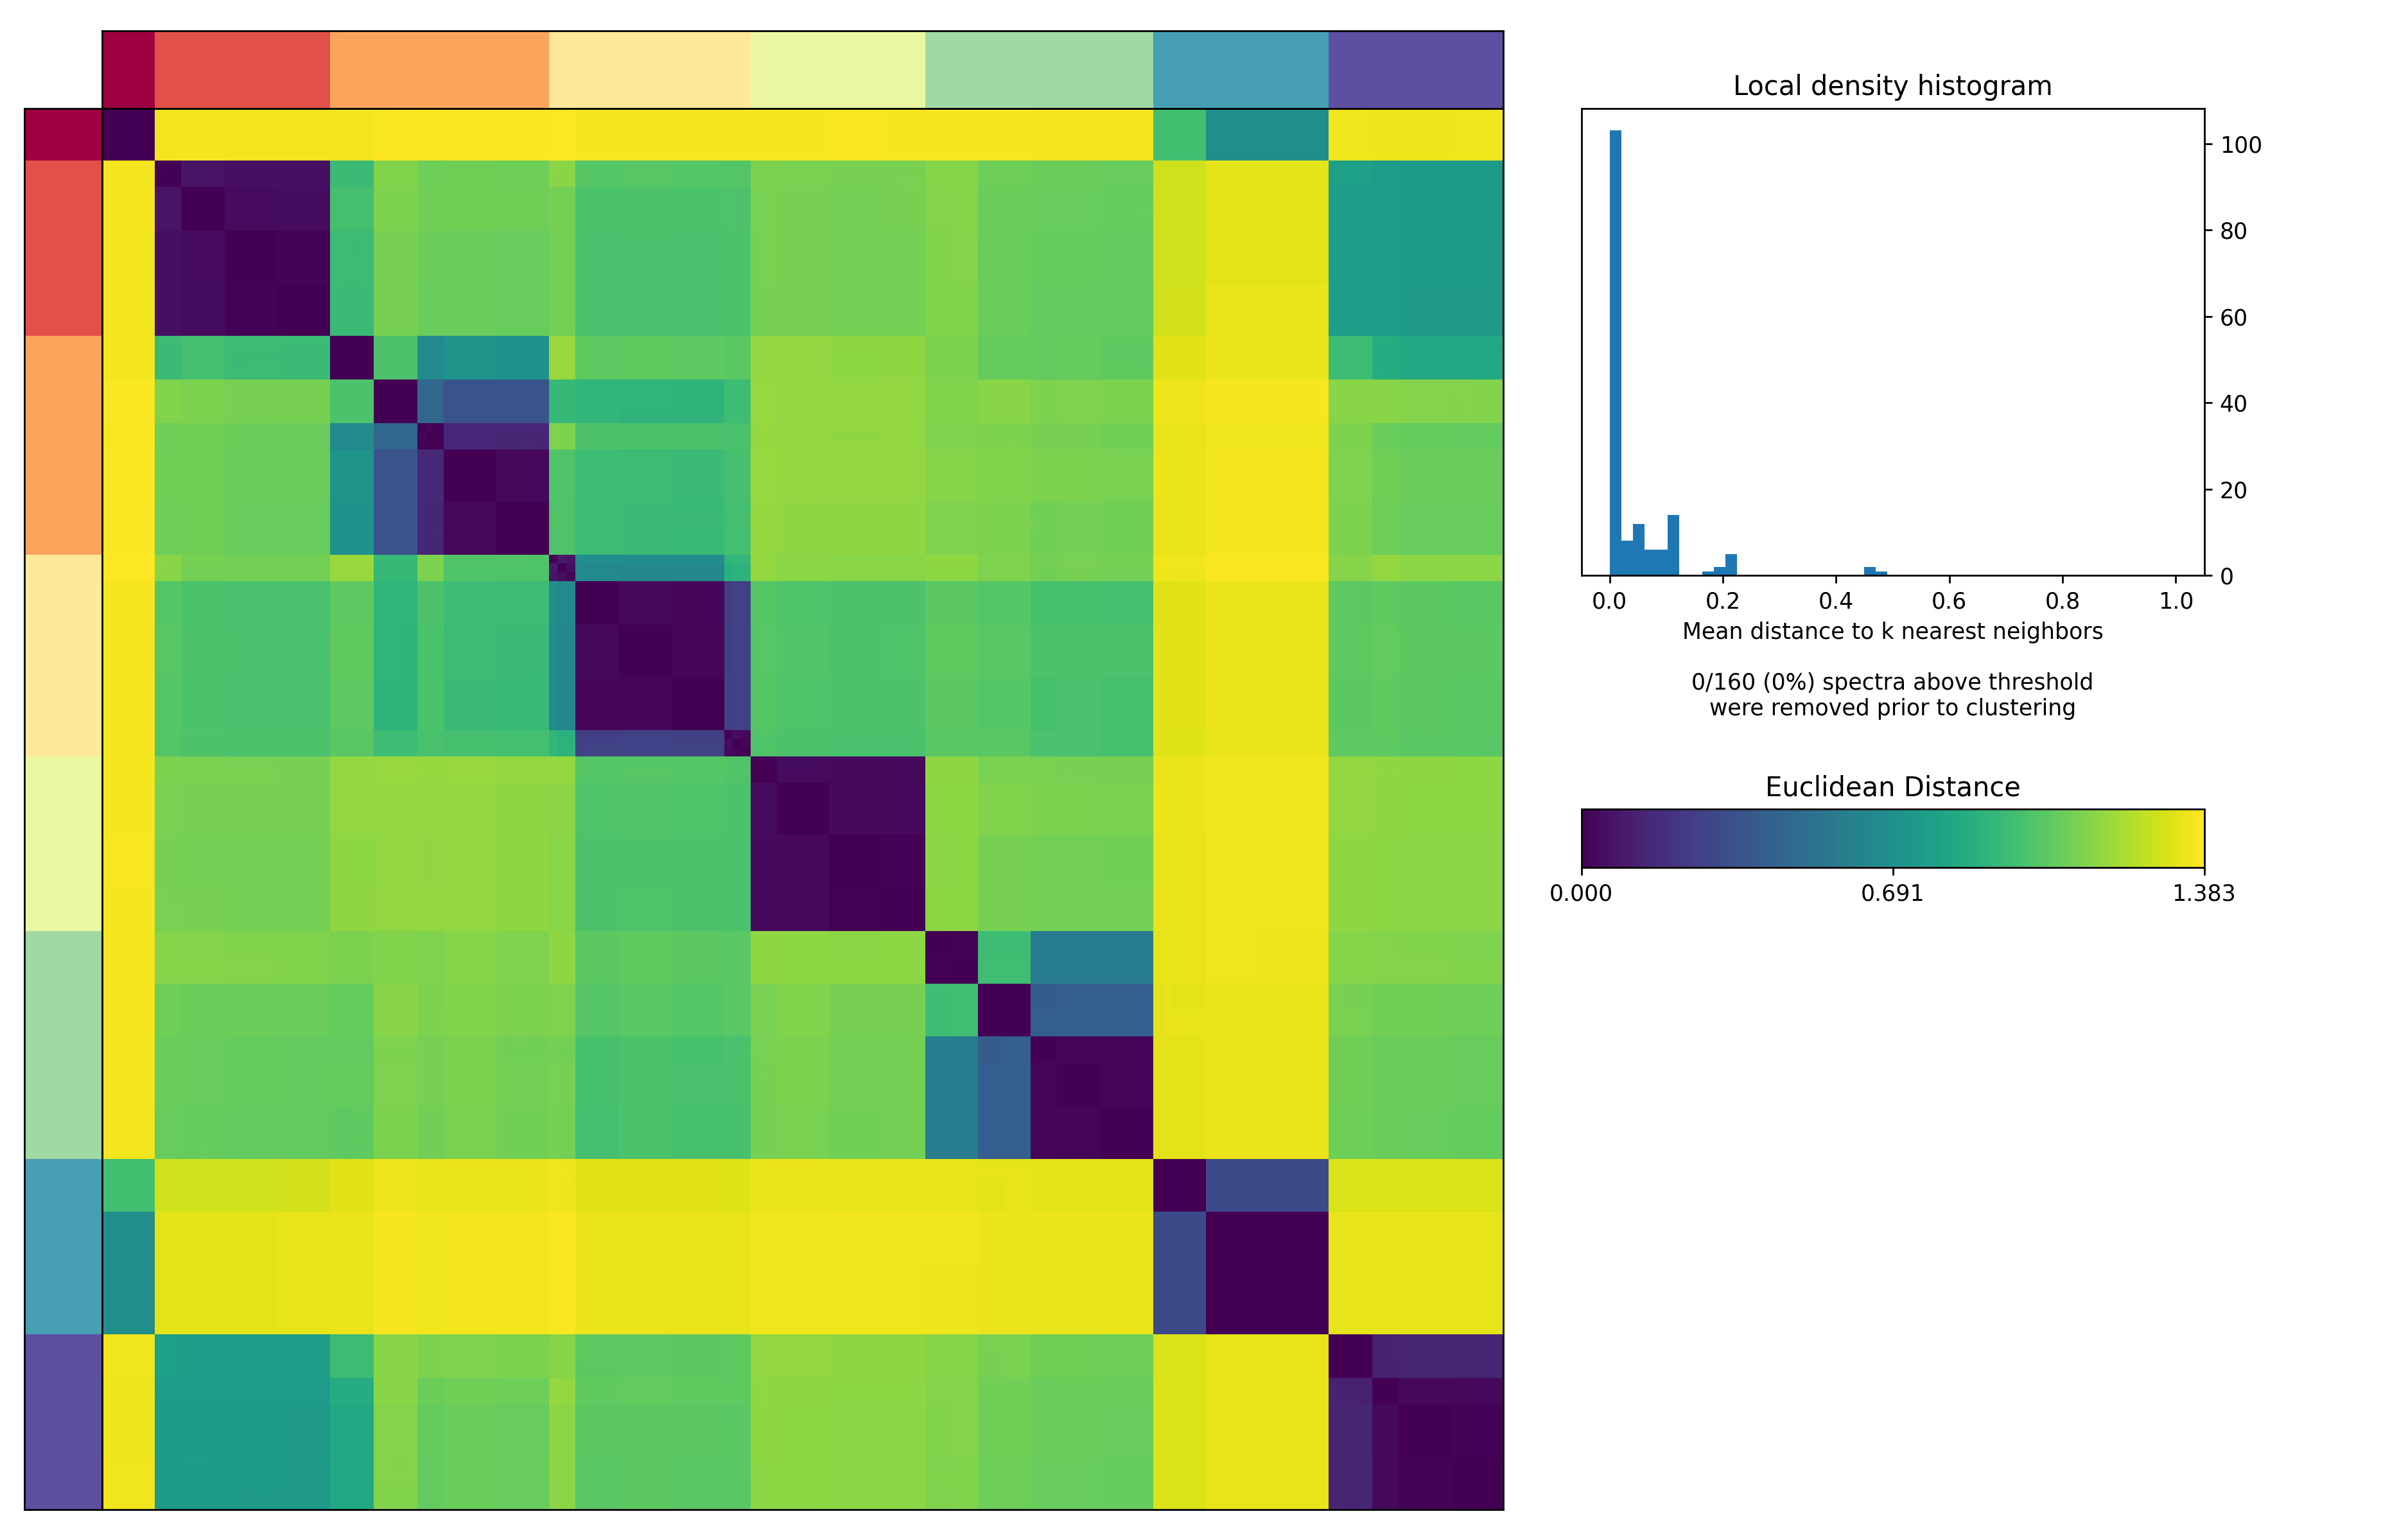

In [49]:
density_threshold_str = str(density_threshold).replace('.', '_')
Image(filename = "example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str),
      width=1000, height=1000)


## AS expected, there is considerably more variability in the solutions of distinct NMF replicates with this run. Thus more caution must be taken in interpreting the results, and ideally cNMF should be run with a larger number of replicates

In [50]:
density_threshold = 0.15

In [51]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
cnmf.consensus(cnmf_obj, selected_K, density_threshold)

/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
/home/sramesh/software/miniconda3/lib/python3.8/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


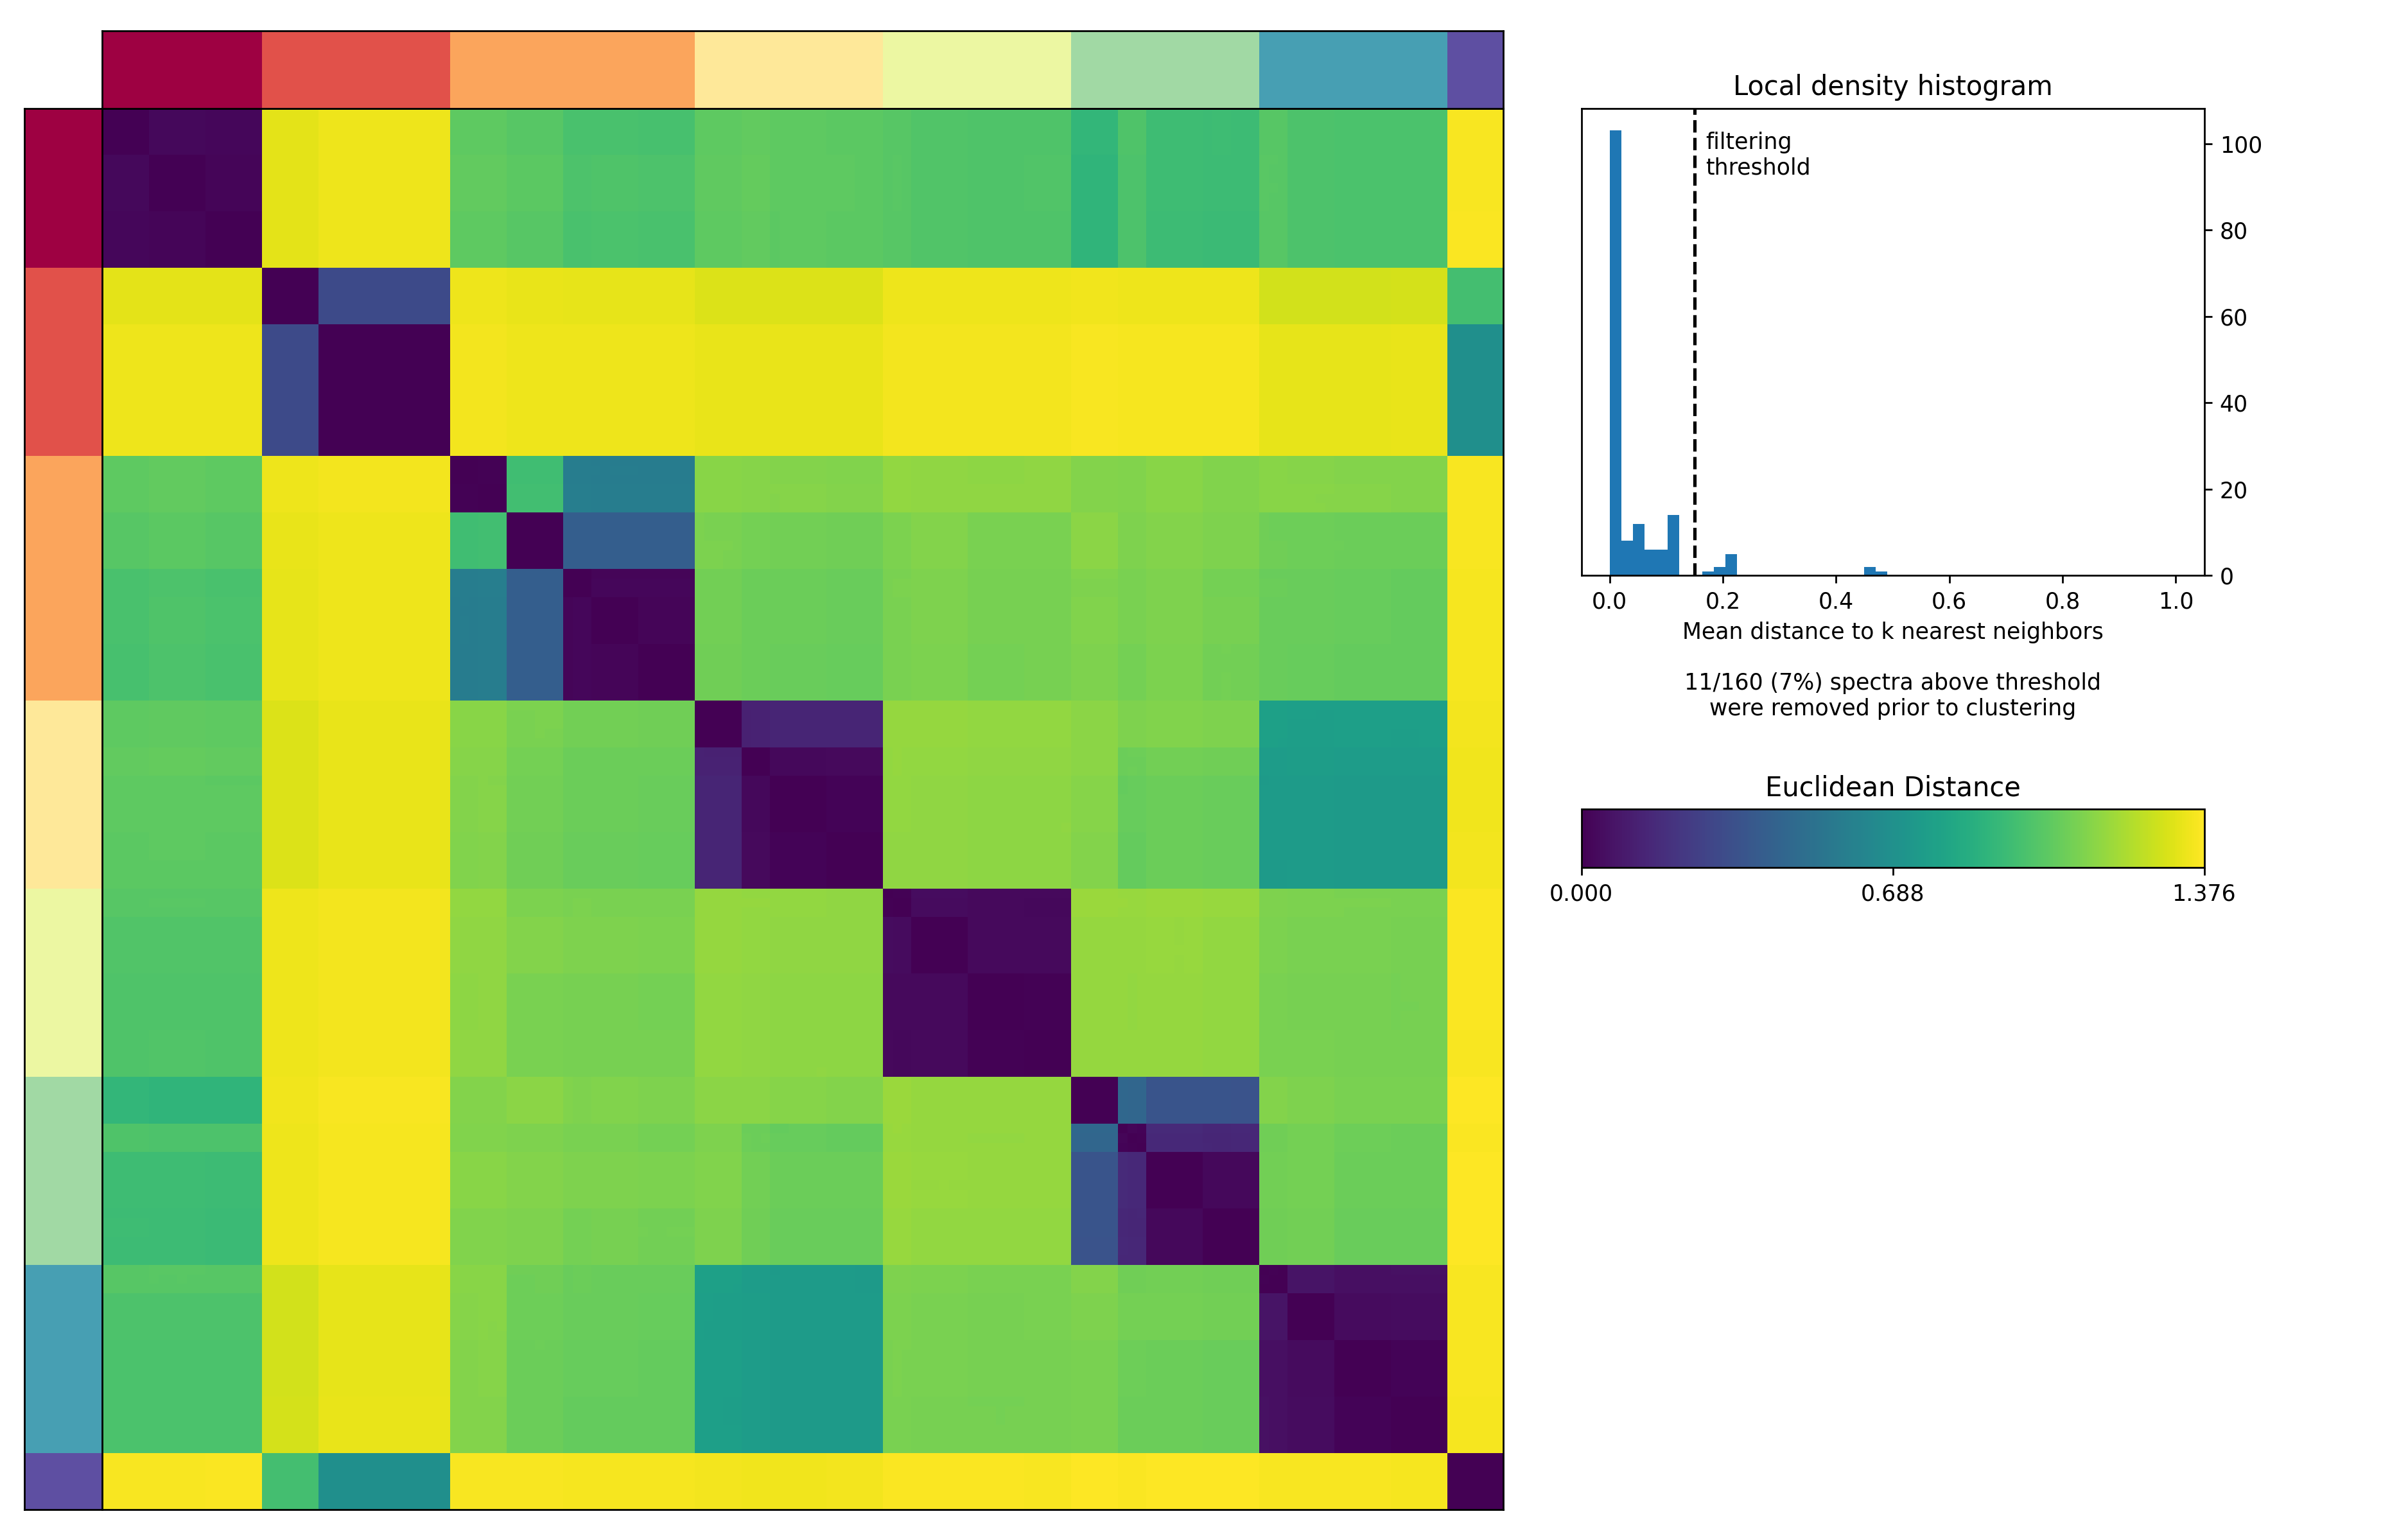

In [52]:
density_threshold_str = str(density_threshold).replace('.', '_')
Image(filename = "example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str),
      width=1000, height=1000)


## It seems that in some iterations the 3rd GEP is getting split into 2 components, while in other iterations, it is being kept as a single one

In [53]:
usage_norm = cnmf.get_usage_df(cnmf_obj, selected_K, density_threshold, normalized=True)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8
AAACATACAACCAC-1,0.855898,0.000000,0.090218,0.007897,0.045988,0.000000,0.000000,0.000000
AAACATTGAGCTAC-1,0.282927,0.000000,0.089663,0.000000,0.040129,0.545364,0.041916,0.000000
AAACATTGATCAGC-1,0.811193,0.000000,0.080410,0.007108,0.025706,0.000000,0.062769,0.012814
AAACCGTGCTTCCG-1,0.035153,0.000000,0.063246,0.312644,0.012472,0.088400,0.454224,0.033861
AAACCGTGTATGCG-1,0.096297,0.001125,0.040861,0.154439,0.645686,0.061591,0.000000,0.000000


In [54]:
adata.obs = adata.obs.iloc[:,[0]]

In [55]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

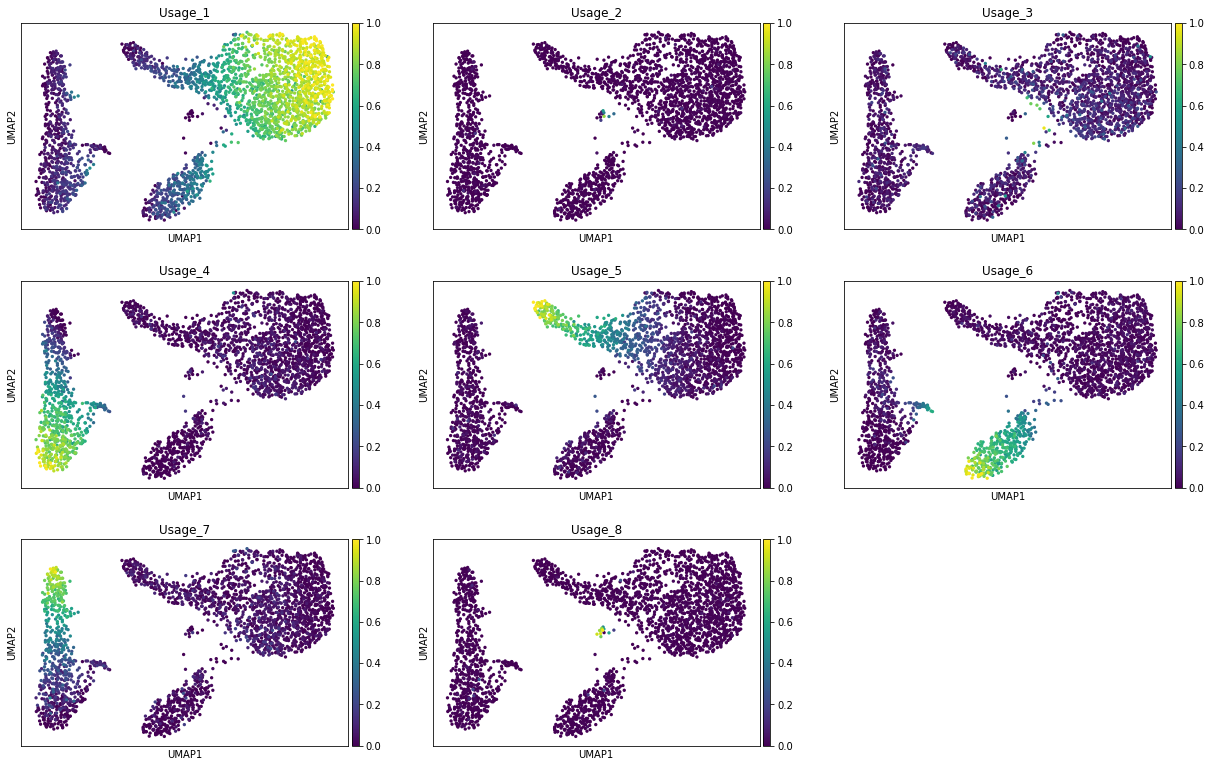

In [56]:
sc.pl.umap(adata, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=1)

In [57]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others

gene_scores = cnmf.get_gene_scores(cnmf_obj, selected_K, density_threshold)
gene_scores.head()

,1,2,3,4,5,6,7,8
AL627309.1,-0.000066,0.000019,-0.000022,0.000586,-0.000026,-0.000318,-0.000223,-0.000102
AP006222.2,0.000026,0.000037,-0.000048,0.000117,-0.000008,-0.000139,-0.000028,-0.000105
RP11-206L10.2,-0.000054,0.000003,-0.000045,-0.000044,-0.000151,0.000999,-0.000106,-0.000110
RP11-206L10.9,-0.000131,-0.000030,-0.000022,0.000561,-0.000117,-0.000080,0.000160,-0.000134
LINC00115,-0.000054,-0.000025,-0.000020,0.000026,0.000208,0.000054,0.000015,-0.000111


In [58]:
## Obtain the top 40 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = cnmf.get_top_genes(cnmf_obj, selected_K, density_threshold, ngenes=40)
top_genes

,1,2,3,4,5,6,7,8
0,RPS12,C2orf88,RRM2,LYZ,NKG7,CD74,FCGR3A,PF4
1,RPS27,PRUNE,CDC6,S100A9,PRF1,HLA-DRA,FCER1G,SDPR
2,RPS25,AATK,MCM10,S100A8,GZMB,HLA-DQB1,LST1,GNG11
3,EEF1A1,GNAZ,TYMS,CD14,GZMA,HLA-DQA1,RP11-290F20.3,HIST1H2AC
4,RPS15A,SMOX,KIAA0101,CST3,GNLY,HLA-DPB1,MS4A7,CLU
5,RPL31,FAM212B,CDC20,FCN1,FGFBP2,HLA-DRB1,IFITM3,LY6G6F
6,RPS6,ESAM,TK1,TYROBP,SPON2,CD79B,IFITM2,SPARC
7,RPS27A,FRMD3,KIFC1,LGALS2,CST7,MS4A1,COTL1,PPBP
8,RPLP2,TSC22D1,BIRC5,GSTP1,CTSW,HLA-DQA2,RHOC,TUBB1
9,RPL23A,TMCC2,BLM,LGALS1,CLIC3,HLA-DPA1,AIF1,MMD


## We find essentially the same GEPs as before except the order is different and the mysterious myeloid program is split into GEP 3 and GEP 8:

 - 1. T-cell identity
 - 2. The mysterious myeloid GEP 1 
 - 3. cell-cycle activity
 - 4. CD14+ monocyte identity
 - 5. NK cell identity
 - 6. B-cell identity 
 - 7. CD16+ monocyte identity
 - 8. The mysterious myeloid GEP 2
 
## Looking more closely at GEP 8, we see some megakaryocyte/platelet lineage markers like [PF4](#https://www.ncbi.nlm.nih.gov/gene/?term=PF4) and [PPBP](https://www.ncbi.nlm.nih.gov/gene/5473) which suggests that a significant fraction of the cells with high usage of that GEP may be megakaryocytes.

## Further exploration would be needed to interpret these programs. A good place to start would be to run cNMF with a larger number of replicates. Additionally, For one could run cNMF or hard-clustering on just the myeloid lineage cells to isolate dendritic cell populations which can be observed on the UMAP as the myeloid branch with higher levels of HLA-DRA. Gene-set enrichment testing could be run using the gene scores as a continuous feature